In [4]:
from ucimlrepo import fetch_ucirepo 
from joblib import dump, load
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

In [5]:
def smote_transform(X,y):
    try:
        smote = SMOTE(random_state=42)
    except:
        smote = SMOTE(random_state=42, k_neighbors=1)
        
    X_train, y_train = smote.fit_resample(X,y)
    
    return X_train, y_train

In [6]:

def get_apr_roc_xgb(params_dict,X,y,smote=False):
    for test_size in [0.8,0.5,0.2]:
        if smote==False:  
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=42)
        else:
            X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=42)
            X_train, y_train = smote_transform(X_train_raw,y_train_raw)
    

        # create model with optimal params
        xgb_opt = XGBClassifier(
            eval_metric='logloss',
            **params_dict,
            random_state=42
        )

        xgb_opt.fit(X_train, y_train)

        y_pred_proba = xgb_opt.predict_proba(X_test)[:,1]
        y_pred_class = xgb_opt.predict(X_test)

        print("Train="+str(round(1-test_size,2)))
        print(classification_report(y_test, y_pred_class,zero_division=0))

        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)  
            ap_score = average_precision_score(y_test, y_pred_proba)
            print(f"AP: {ap_score:.4f}")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not calculate ROC-AUC: {e}")

        print(" ")
        print(" ")
        
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

        plt.plot(recall, precision, label=f'AP: {ap_score:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()
        
    return xgb_opt

In [7]:
def create_nn(feat_count, learning_rate=0.001):
    model = Sequential([Input(shape=(feat_count,)),
                        Dense(64, activation="relu"),
                        Dense(32, activation="relu"), 
                        Dense(1, activation="sigmoid")]) # output layer
    
    model.compile(optimizer = Adam(learning_rate=learning_rate),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
                  
    return model

def get_apr_roc_nn(params_dict,X,y,feat_count,smote=False):
    # train on 3 splits
    for test_size in [0.8,0.5,0.2]:
        if smote==False:  
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=42)
        else:
            X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=42)
            X_train, y_train = smote_transform(X_train_raw,y_train_raw)
            
        # create model with optimal learning rate
        nn_opt = create_nn(
            learning_rate=params_dict.get('model__learning_rate'),
            feat_count=feat_count
        )
        
        # early stop
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        nn_opt.fit(X_train, y_train,
                   batch_size=params_dict.get('batch_size'),
                   epochs=200,
                   validation_split=0.2,
                   callbacks=[early_stop],
                   verbose=0)

        y_pred_proba = nn_opt.predict(X_test)
        y_pred_class = (y_pred_proba >= 0.3).astype(float) 

        print("Train="+str(round(1-test_size,2)))
        print(classification_report(y_test, y_pred_class,zero_division=0))
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)  
            ap_score = average_precision_score(y_test, y_pred_proba)
            print(f"AP: {ap_score:.4f}")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not calculate ROC-AUC: {e}")

        print(" ")
        print(" ")
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        
        plt.plot(recall, precision, label=f'AP: {ap_score:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()
        
    return nn_opt

In [8]:
def get_apr_roc_rf(params_dict,X,y,smote=False):
    for test_size in [0.8,0.5,0.2]:
        if smote==False:  
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=42)
        else:
            X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=42)
            X_train, y_train = smote_transform(X_train_raw,y_train_raw)
            
        # create model with optimal params
        rf_opt = RandomForestClassifier(**params_dict, random_state=42)

        rf_opt.fit(X_train, y_train)

        y_pred_proba = rf_opt.predict_proba(X_test)[:,1]
        y_pred_class = rf_opt.predict(X_test)

        print("Train="+str(round(1-test_size,2)))
        print(classification_report(y_test, y_pred_class,zero_division=0))

        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)  
            ap_score = average_precision_score(y_test, y_pred_proba)
            print(f"AP: {ap_score:.4f}")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not calculate ROC-AUC: {e}")

        print(" ")
        print(" ")
        
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

        plt.plot(recall, precision, label=f'AP: {ap_score:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()
        
    return rf_opt

In [9]:
def get_apr_roc_sgd(params_dict, X, y, smote=False):
    for test_size in [0.8,0.5,0.2]:
        if smote==False:  
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=42)
        else:
            X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=42)
            X_train, y_train = smote_transform(X_train_raw,y_train_raw)
            
        sgd_opt = SGDClassifier(
            **params_dict, 
            learning_rate='optimal',
            penalty='elasticnet',
            max_iter=1000,
            random_state=42
        )

        sgd_opt.fit(X_train, y_train)

        y_pred = sgd_opt.predict(X_test)
        y_pred_proba = sgd_opt.predict_proba(X_test)[:,1]

        print("Train="+str(round(1 - test_size, 2)))
        print(classification_report(y_test, y_pred, zero_division=0))
        
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)  
            ap_score = average_precision_score(y_test, y_pred_proba)
            print(f"AP: {ap_score:.4f}")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not calculate ROC-AUC: {e}")
        
        print(" ")
        print(" ")

        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

        plt.plot(recall, precision, label=f'AP: {ap_score:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()
        
    return sgd_opt

In [10]:
def get_apr_roc_svm(base_models, params_dict, X, y):
    for test_size in [0.8,0.5,0.2]:
        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42,shuffle=True)    

        meta_trainl=[]
        meta_testl=[]

        for model in base_models:
            if hasattr(model, "predict_proba"):
                meta_trainl.append(model.predict_proba(X_train)[:,1])
                meta_testl.append(model.predict_proba(X_test)[:,1])
            else:
                meta_trainl.append(model.predict(X_train).ravel())
                meta_testl.append(model.predict(X_test).ravel())    #NN doesnt have predict proba

        meta_train = np.array(meta_trainl).T
        meta_test = np.array(meta_testl).T

        svm_meta_opt = SVC(
            **params_dict, 
            probability=True,
            random_state=42
        )

        svm_meta_opt.fit(meta_train, y_train)

        y_pred = svm_meta_opt.predict(meta_test)
        y_pred_proba = svm_meta_opt.predict_proba(meta_test)[:,1]

        print("Train="+str(round(1 - test_size, 2)))
        print(classification_report(y_test, y_pred, zero_division=0))
        
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)  
            ap_score = average_precision_score(y_test, y_pred_proba)
            print(f"AP: {ap_score:.4f}")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not calculate ROC-AUC: {e}")
        
        print(" ")
        print(" ")       
        
        print(" ")
        print(" ")
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

        plt.plot(recall, precision, label=f'AP: {ap_score:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

## <b>WINE</b>

In [145]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X_wine_raw = wine_quality.data.features 
y_wine_raw = wine_quality.data.targets 

In [146]:
# Load trained models w best params
xgb = load("trained/xgb_opt_WINE.joblib")
nn = load("trained/nn_opt_WINE.joblib")
rf = load("trained/rf_opt_WINE.joblib")
sgd = load("trained/sgd_opt_WINE.joblib")
svm = load("trained/svm_meta_opt_WINE.joblib")

In [162]:
# normalizing
scaler = StandardScaler()
X_wine = scaler.fit_transform(X_wine_raw)
X_wine

array([[ 0.14247327,  2.18883292, -2.19283252, ...,  1.81308951,
         0.19309677, -0.91546416],
       [ 0.45103572,  3.28223494, -2.19283252, ..., -0.11507303,
         0.99957862, -0.58006813],
       [ 0.45103572,  2.55330026, -1.91755268, ...,  0.25811972,
         0.79795816, -0.58006813],
       ...,
       [-0.55179227, -0.6054167 , -0.88525328, ..., -1.42124765,
        -0.47897144, -0.91546416],
       [-1.32319841, -0.30169391, -0.12823371, ...,  0.75571005,
        -1.016626  ,  1.9354021 ],
       [-0.93749534, -0.78765037,  0.42232597, ...,  0.25811972,
        -1.41986693,  1.09691202]])

In [148]:
# make binary and ravel

y_encode = y_wine_raw.copy()
y_encode['quality'] = (y_wine_raw['quality'] >= 6).astype(float)

y_wine = np.array(y_encode).ravel()

y_wine

array([0., 0., 0., ..., 1., 1., 1.])

## XGB - WINE

Train=0.2
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      1900
         1.0       0.81      0.81      0.81      3298

    accuracy                           0.76      5198
   macro avg       0.74      0.74      0.74      5198
weighted avg       0.76      0.76      0.76      5198

AP: 0.8810
ROC-AUC: 0.8186
 
 


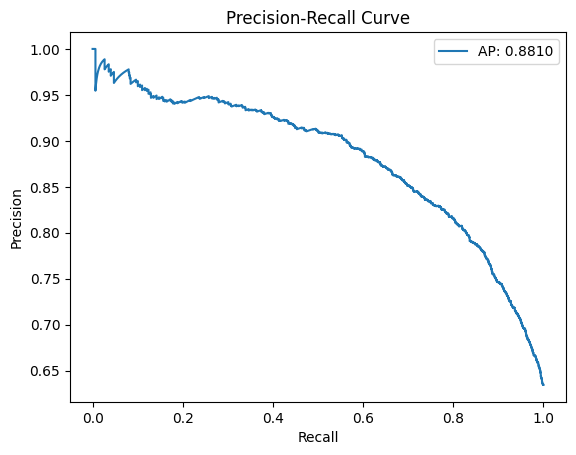

Train=0.5
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72      1157
         1.0       0.84      0.84      0.84      2092

    accuracy                           0.80      3249
   macro avg       0.78      0.78      0.78      3249
weighted avg       0.80      0.80      0.80      3249

AP: 0.9069
ROC-AUC: 0.8600
 
 


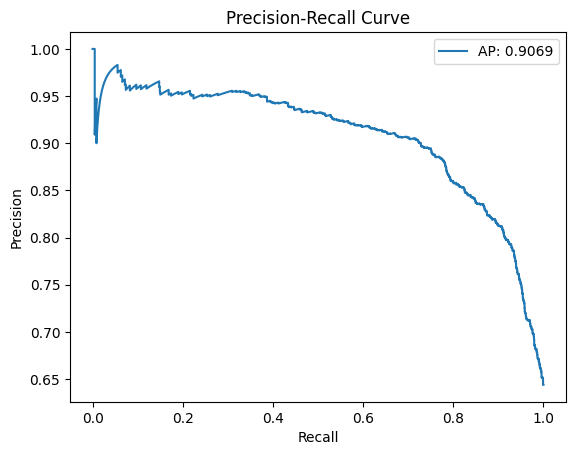

Train=0.8
              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72       451
         1.0       0.85      0.86      0.86       849

    accuracy                           0.81      1300
   macro avg       0.79      0.79      0.79      1300
weighted avg       0.81      0.81      0.81      1300

AP: 0.9135
ROC-AUC: 0.8667
 
 


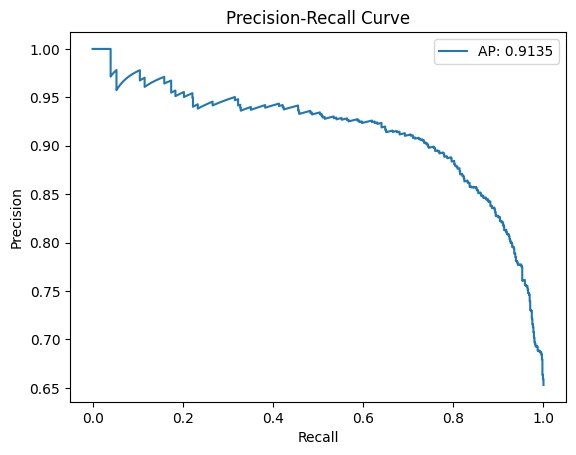

In [209]:
xgb_opt_w=get_apr_roc_xgb({'n_estimators':200, 'learning_rate':0.1,'max_depth':10}, X=X_wine, y=y_wine)

## RF - WINE

Train=0.2
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67      1900
         1.0       0.81      0.83      0.82      3298

    accuracy                           0.77      5198
   macro avg       0.75      0.74      0.75      5198
weighted avg       0.76      0.77      0.77      5198

AP: 0.8945
ROC-AUC: 0.8363
 
 


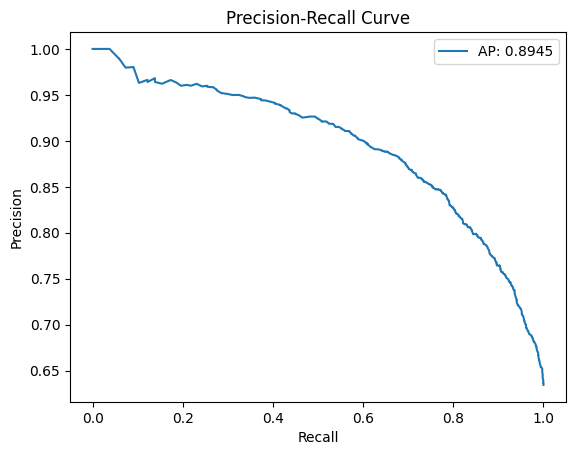

Train=0.5
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73      1157
         1.0       0.85      0.85      0.85      2092

    accuracy                           0.81      3249
   macro avg       0.79      0.79      0.79      3249
weighted avg       0.81      0.81      0.81      3249

AP: 0.9266
ROC-AUC: 0.8792
 
 


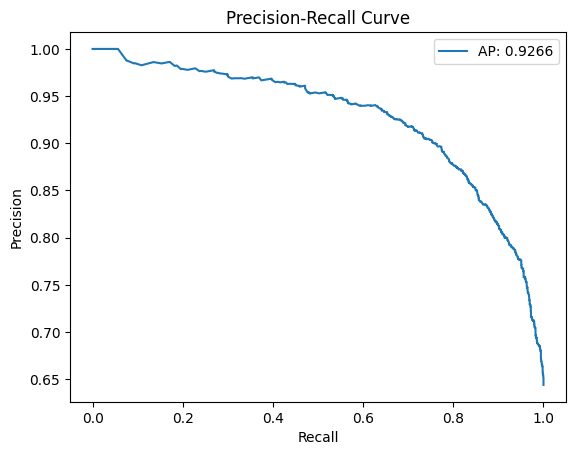

Train=0.8
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       451
         1.0       0.86      0.87      0.86       849

    accuracy                           0.82      1300
   macro avg       0.80      0.80      0.80      1300
weighted avg       0.82      0.82      0.82      1300

AP: 0.9354
ROC-AUC: 0.8896
 
 


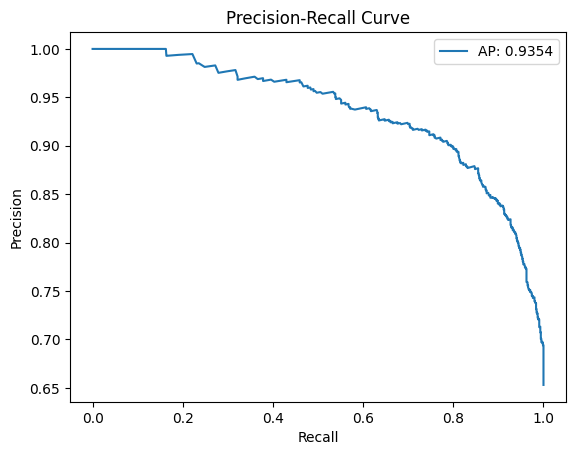

In [210]:
rf_opt_w=get_apr_roc_rf({'n_estimators':200, 'min_samples_split':2,'max_depth':20}, 
                        X=X_wine, y=y_wine)

## NN - WINE

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
Train=0.2
              precision    recall  f1-score   support

         0.0       0.73      0.40      0.52      1900
         1.0       0.73      0.91      0.81      3298

    accuracy                           0.73      5198
   macro avg       0.73      0.66      0.66      5198
weighted avg       0.73      0.73      0.70      5198

AP: 0.8731
ROC-AUC: 0.8063
 
 


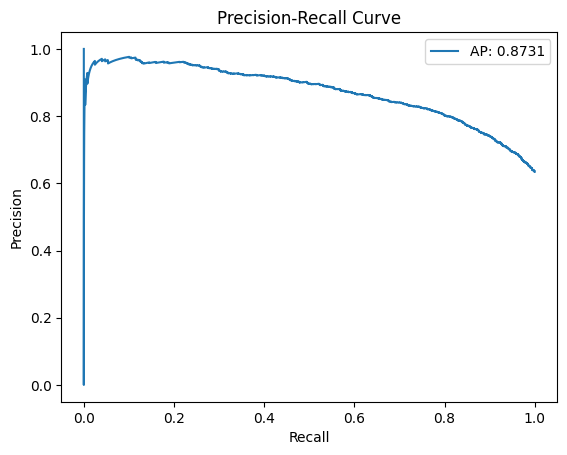

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
Train=0.5
              precision    recall  f1-score   support

         0.0       0.73      0.45      0.56      1157
         1.0       0.75      0.91      0.82      2092

    accuracy                           0.75      3249
   macro avg       0.74      0.68      0.69      3249
weighted avg       0.74      0.75      0.73      3249

AP: 0.8849
ROC-AUC: 0.8189
 
 


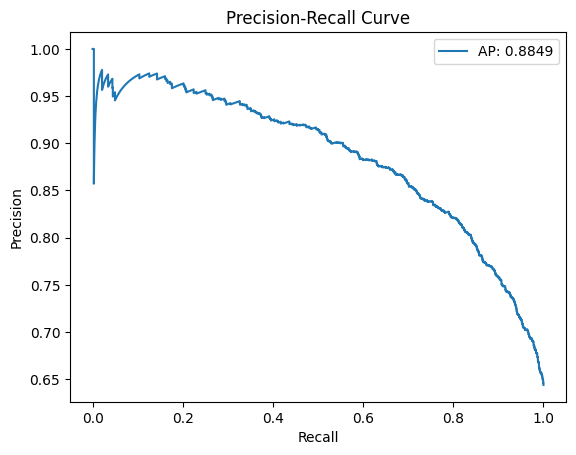

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train=0.8
              precision    recall  f1-score   support

         0.0       0.71      0.45      0.56       451
         1.0       0.76      0.90      0.82       849

    accuracy                           0.75      1300
   macro avg       0.74      0.68      0.69      1300
weighted avg       0.74      0.75      0.73      1300

AP: 0.8870
ROC-AUC: 0.8205
 
 


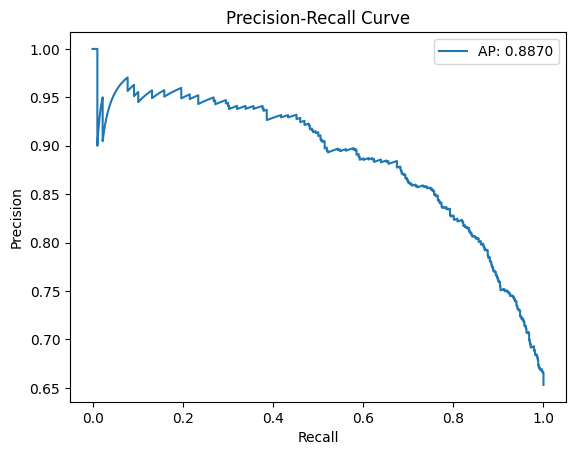

In [211]:
nn_opt_w=get_apr_roc_nn({'batch_size': 128, 'model__learning_rate': 0.01},
                        X=X_wine,y=y_wine,
                       feat_count=len(X_wine[0]))

## SGD - WINE

Train=0.2
              precision    recall  f1-score   support

         0.0       0.64      0.62      0.63      1900
         1.0       0.79      0.80      0.79      3298

    accuracy                           0.73      5198
   macro avg       0.71      0.71      0.71      5198
weighted avg       0.73      0.73      0.73      5198

AP: 0.8501
ROC-AUC: 0.7833
 
 


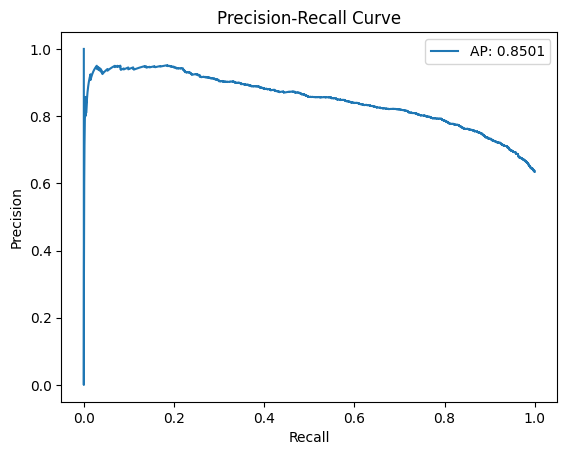

Train=0.5
              precision    recall  f1-score   support

         0.0       0.65      0.55      0.60      1157
         1.0       0.77      0.84      0.80      2092

    accuracy                           0.74      3249
   macro avg       0.71      0.70      0.70      3249
weighted avg       0.73      0.74      0.73      3249

AP: 0.8622
ROC-AUC: 0.7907
 
 


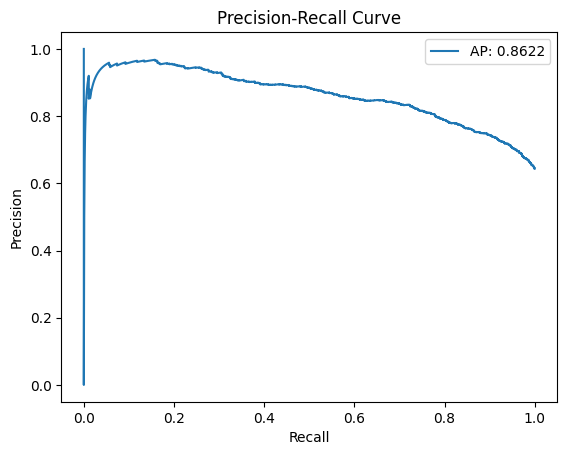

Train=0.8
              precision    recall  f1-score   support

         0.0       0.60      0.59      0.60       451
         1.0       0.79      0.79      0.79       849

    accuracy                           0.72      1300
   macro avg       0.69      0.69      0.69      1300
weighted avg       0.72      0.72      0.72      1300

AP: 0.8502
ROC-AUC: 0.7784
 
 


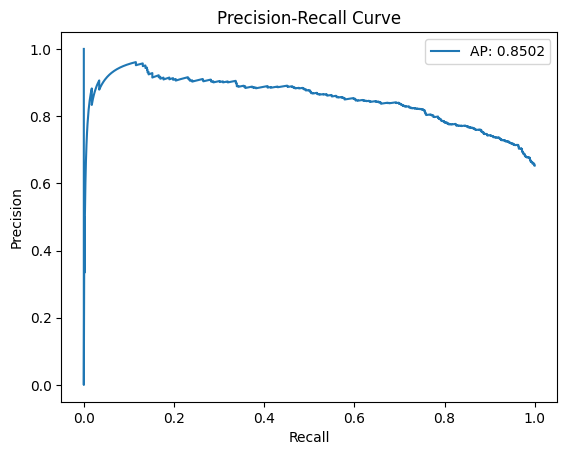

In [212]:
sgd_opt_w=get_apr_roc_sgd({'alpha': 0.001, 'l1_ratio': 0.85, 'loss': 'log_loss', 'tol': 1e-05}, X=X_wine, y=y_wine)

## SVM - WINE


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
Train=0.2
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1900
         1.0       0.96      0.97      0.96      3298

    accuracy                           0.95      5198
   macro avg       0.95      0.95      0.95      5198
weighted avg       0.95      0.95      0.95      5198

AP: 0.9873
ROC-AUC: 0.9806
 
 
 
 


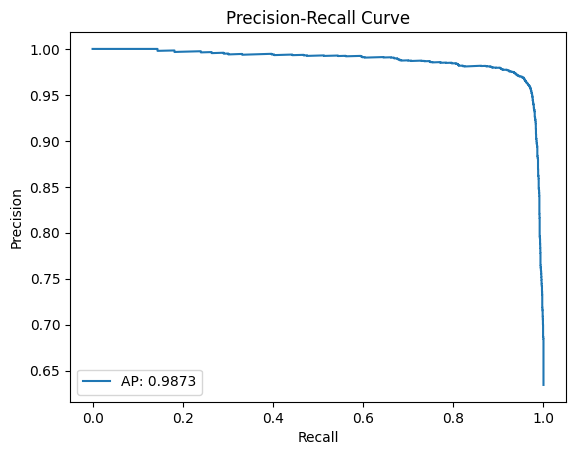

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
Train=0.5
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      1157
         1.0       0.94      0.94      0.94      2092

    accuracy                           0.93      3249
   macro avg       0.92      0.92      0.92      3249
weighted avg       0.93      0.93      0.93      3249

AP: 0.9819
ROC-AUC: 0.9706
 
 
 
 


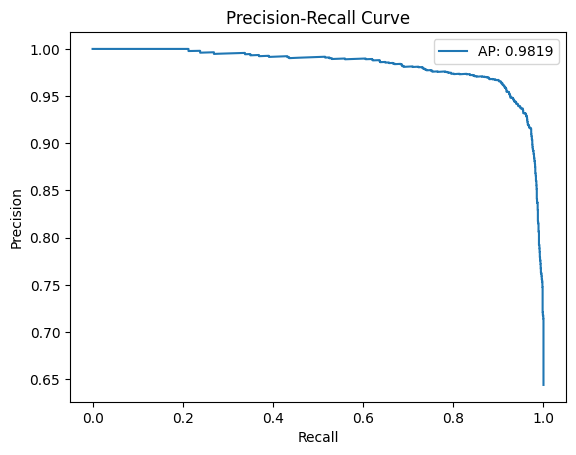

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
Train=0.8
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       451
         1.0       0.86      0.86      0.86       849

    accuracy                           0.81      1300
   macro avg       0.79      0.79      0.79      1300
weighted avg       0.81      0.81      0.81      1300

AP: 0.9312
ROC-AUC: 0.8827
 
 
 
 


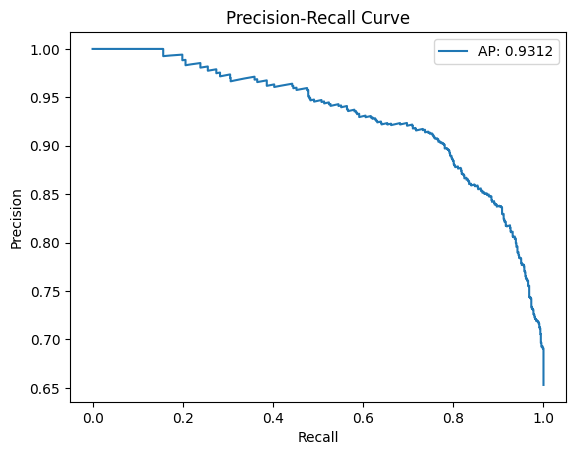

In [213]:
get_apr_roc_svm(params_dict={'C': 0.1, 'gamma': 0.01}, 
                base_models=[xgb_opt_w,rf_opt_w,nn_opt_w,sgd_opt_w], 
                X=X_wine, y=y_wine)

## <b>SEPSIS</b>

In [3]:
# fetch dataset 
sepsis_survival_minimal_clinical_records = fetch_ucirepo(id=827) 
  
# data (as pandas dataframes) 
X_sepsis_raw = sepsis_survival_minimal_clinical_records.data.features 
y_sepsis_raw = sepsis_survival_minimal_clinical_records.data.targets 

In [134]:
X_norway = X_sepsis_raw[:-137] 
y_norway = y_sepsis_raw[:-137]

In [138]:
# normalizing
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_norway[['age_years', 'episode_number']])

X_sepsis = X_norway.copy()
X_sepsis['age_years'] = X_num_scaled[:,0]
X_sepsis['episode_number'] = X_num_scaled[:,1]

X_sepsis

,age_years,sex_0male_1female,episode_number
0,-1.729837,1,-0.464727
1,-1.771285,1,-0.464727
2,-1.729837,1,-0.464727
3,0.591243,0,-0.464727
4,0.384004,0,-0.464727
...,...,...,...
110199,-2.600242,0,-0.464727
110200,-2.600242,1,-0.464727
110201,0.301108,1,-0.464727
110202,-2.600242,0,-0.464727


In [155]:
y_sepsis = np.array(y_norway.astype(float)).ravel()

y_sepsis

array([1., 1., 1., ..., 1., 1., 1.])

## XGB - SEPSIS

Train=0.2
              precision    recall  f1-score   support

         0.0       0.12      0.68      0.20      6533
         1.0       0.96      0.58      0.72     81631

    accuracy                           0.59     88164
   macro avg       0.54      0.63      0.46     88164
weighted avg       0.90      0.59      0.69     88164

AP: 0.9626
ROC-AUC: 0.6787
 
 


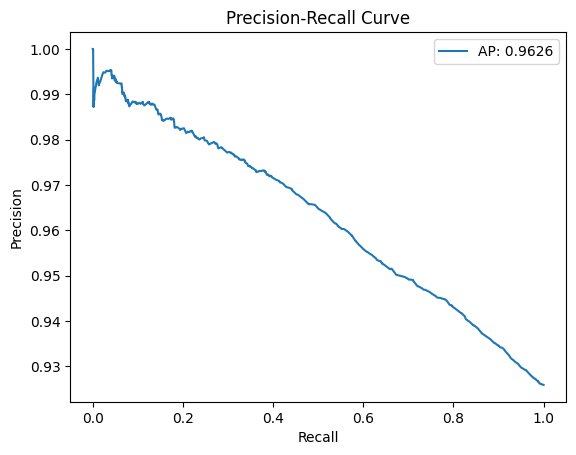

Train=0.5
              precision    recall  f1-score   support

         0.0       0.12      0.69      0.20      4062
         1.0       0.96      0.58      0.72     51040

    accuracy                           0.59     55102
   macro avg       0.54      0.64      0.46     55102
weighted avg       0.90      0.59      0.68     55102

AP: 0.9642
ROC-AUC: 0.6864
 
 


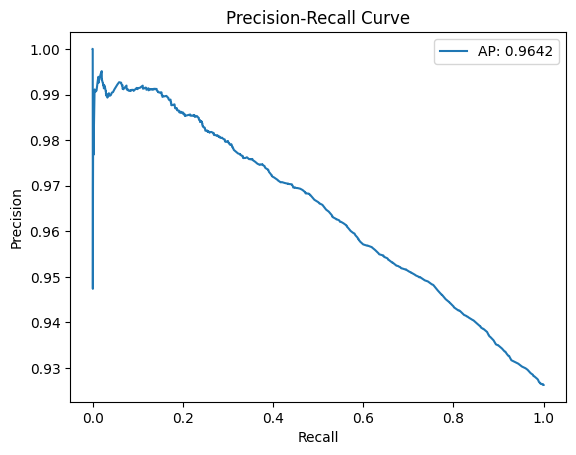

Train=0.8
              precision    recall  f1-score   support

         0.0       0.11      0.76      0.19      1613
         1.0       0.97      0.52      0.68     20428

    accuracy                           0.54     22041
   macro avg       0.54      0.64      0.44     22041
weighted avg       0.90      0.54      0.64     22041

AP: 0.9659
ROC-AUC: 0.6909
 
 


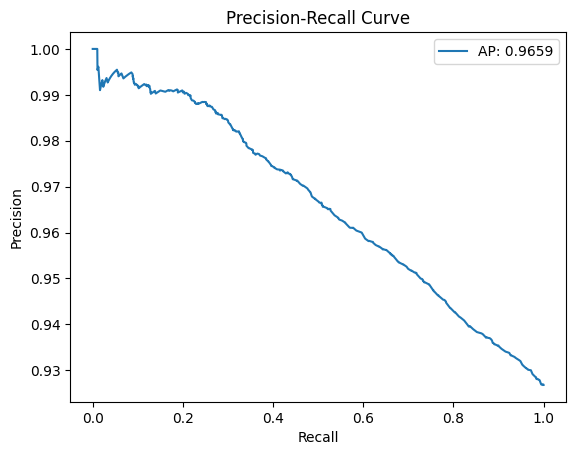

In [182]:
xgb_opt_s=get_apr_roc_xgb({'n_estimators':200, 'learning_rate':0.1,'max_depth':10}, 
                          X=X_sepsis, y=y_sepsis,
                          smote=True)

## RF - SEPSIS

Train=0.2
              precision    recall  f1-score   support

         0.0       0.12      0.62      0.20      6533
         1.0       0.95      0.63      0.76     81631

    accuracy                           0.63     88164
   macro avg       0.54      0.62      0.48     88164
weighted avg       0.89      0.63      0.71     88164

AP: 0.9605
ROC-AUC: 0.6748
 
 


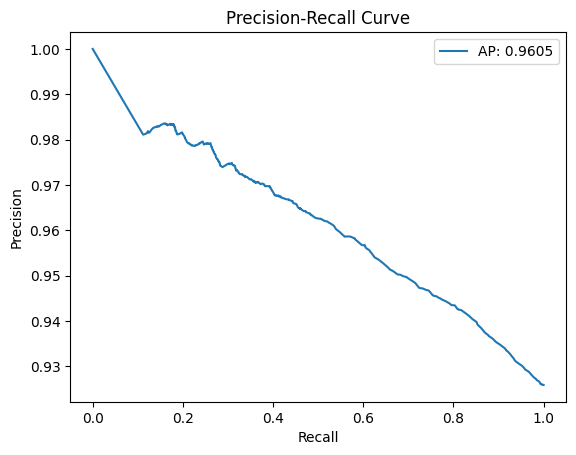

Train=0.5
              precision    recall  f1-score   support

         0.0       0.12      0.68      0.20      4062
         1.0       0.96      0.59      0.73     51040

    accuracy                           0.59     55102
   macro avg       0.54      0.63      0.46     55102
weighted avg       0.90      0.59      0.69     55102

AP: 0.9624
ROC-AUC: 0.6823
 
 


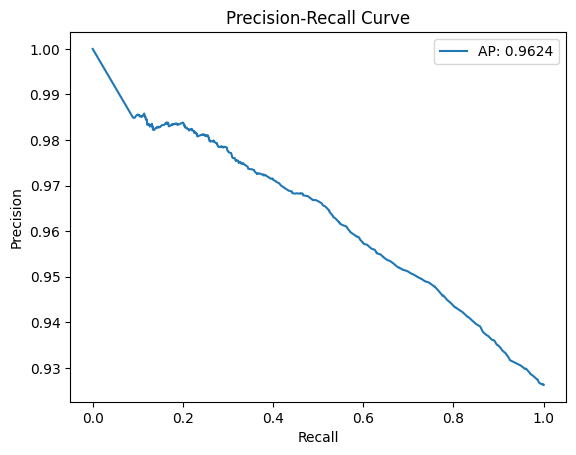

Train=0.8
              precision    recall  f1-score   support

         0.0       0.11      0.76      0.19      1613
         1.0       0.96      0.52      0.68     20428

    accuracy                           0.54     22041
   macro avg       0.54      0.64      0.44     22041
weighted avg       0.90      0.54      0.64     22041

AP: 0.9643
ROC-AUC: 0.6874
 
 


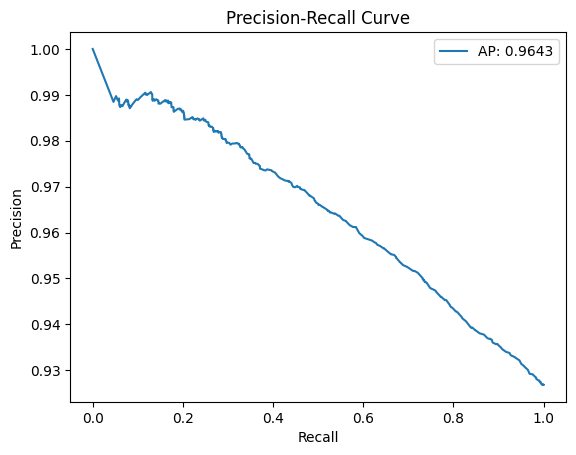

In [186]:
rf_opt_s=get_apr_roc_rf({'n_estimators':200, 'min_samples_split':2,'max_depth':20}, 
                        X=X_sepsis, y=y_sepsis,
                        smote=True)

## NN - SEPSIS

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step
Train=0.2
              precision    recall  f1-score   support

         0.0       0.17      0.00      0.00      6533
         1.0       0.93      1.00      0.96     81631

    accuracy                           0.93     88164
   macro avg       0.55      0.50      0.48     88164
weighted avg       0.87      0.93      0.89     88164

AP: 0.9671
ROC-AUC: 0.7021
 
 


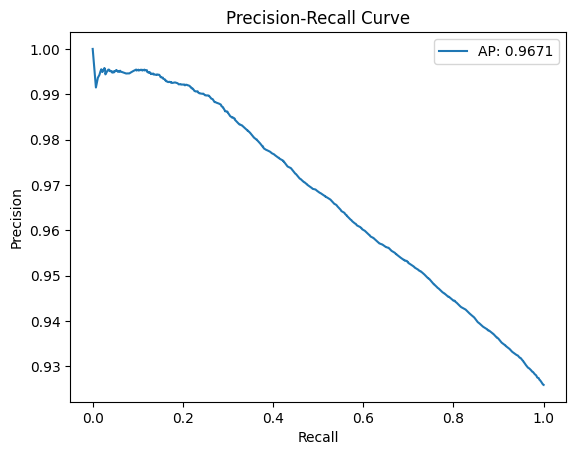

1722/1722 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step
Train=0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4062
         1.0       0.93      1.00      0.96     51040

    accuracy                           0.93     55102
   macro avg       0.46      0.50      0.48     55102
weighted avg       0.86      0.93      0.89     55102

AP: 0.9678
ROC-AUC: 0.7049
 
 


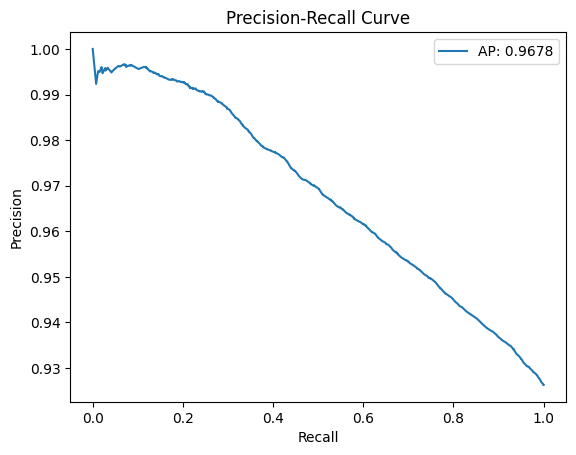

689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
Train=0.8
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1613
         1.0       0.93      1.00      0.96     20428

    accuracy                           0.93     22041
   macro avg       0.46      0.50      0.48     22041
weighted avg       0.86      0.93      0.89     22041

AP: 0.9676
ROC-AUC: 0.7010
 
 


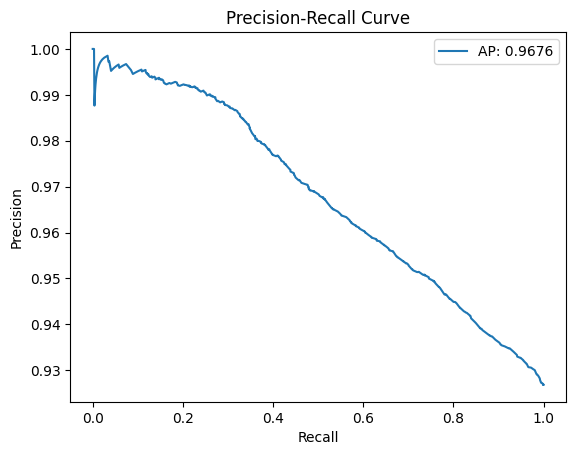

In [187]:
nn_opt_s=get_apr_roc_nn({'batch_size': 128, 'model__learning_rate': 0.001},
                        X=X_sepsis,y=y_sepsis,
                       feat_count=X_sepsis.shape[1],
                       smote=True)

## SGD - SEPSIS

Train=0.2
              precision    recall  f1-score   support

         0.0       0.12      0.73      0.20      6533
         1.0       0.96      0.57      0.71     81631

    accuracy                           0.58     88164
   macro avg       0.54      0.65      0.46     88164
weighted avg       0.90      0.58      0.68     88164

AP: 0.9670
ROC-AUC: 0.7026
 
 


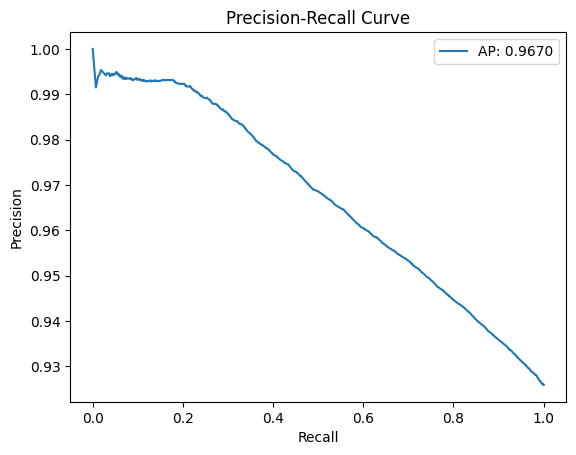

Train=0.5
              precision    recall  f1-score   support

         0.0       0.12      0.74      0.20      4062
         1.0       0.96      0.56      0.71     51040

    accuracy                           0.57     55102
   macro avg       0.54      0.65      0.46     55102
weighted avg       0.90      0.57      0.67     55102

AP: 0.9673
ROC-AUC: 0.7037
 
 


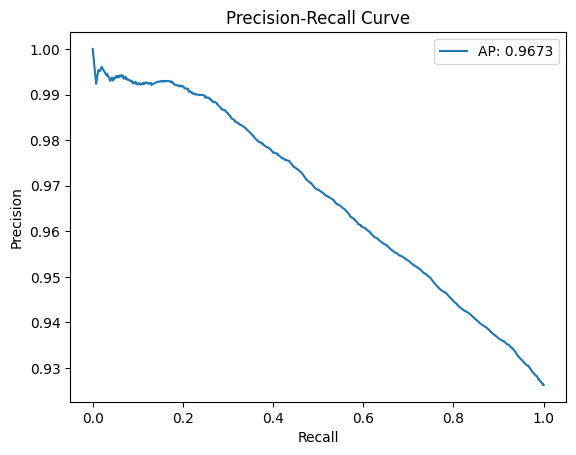

Train=0.8
              precision    recall  f1-score   support

         0.0       0.12      0.74      0.20      1613
         1.0       0.96      0.56      0.71     20428

    accuracy                           0.57     22041
   macro avg       0.54      0.65      0.45     22041
weighted avg       0.90      0.57      0.67     22041

AP: 0.9672
ROC-AUC: 0.6990
 
 


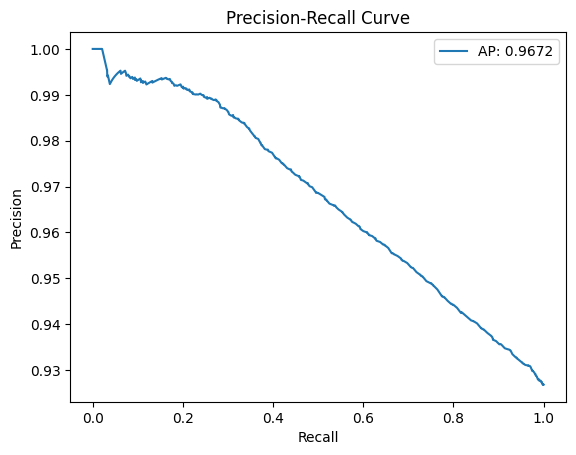

In [188]:
sgd_opt_s=get_apr_roc_sgd({'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'log_loss', 'tol': 1e-05}, 
                          X=X_sepsis, y=y_sepsis,
                          smote=True)

## SVM - SEPSIS

689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step
Train=0.2
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6533
         1.0       0.93      1.00      0.96     81631

    accuracy                           0.93     88164
   macro avg       0.46      0.50      0.48     88164
weighted avg       0.86      0.93      0.89     88164

AP: 0.8914
ROC-AUC: 0.3073
 
 
 
 


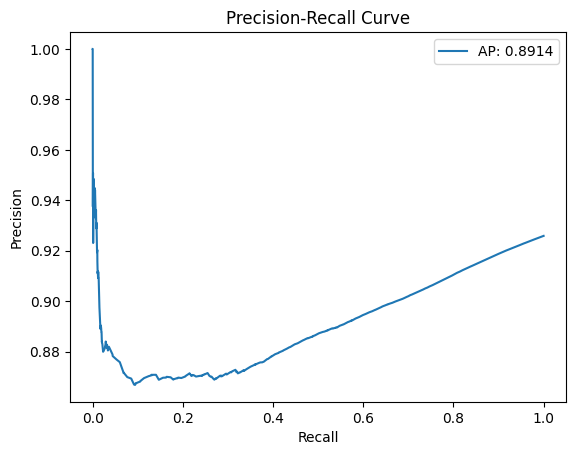

1722/1722 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step
Train=0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4062
         1.0       0.93      1.00      0.96     51040

    accuracy                           0.93     55102
   macro avg       0.46      0.50      0.48     55102
weighted avg       0.86      0.93      0.89     55102

AP: 0.8907
ROC-AUC: 0.3081
 
 
 
 


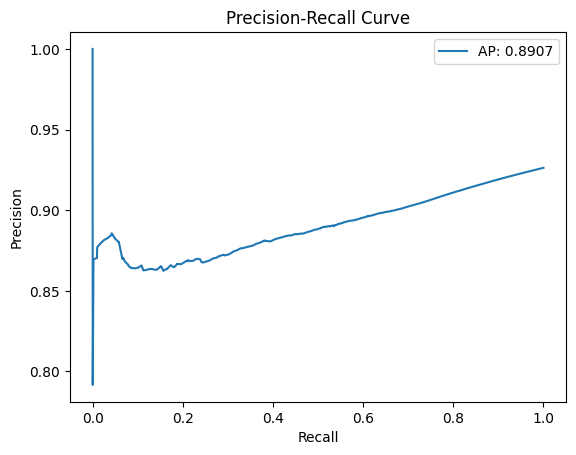

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
Train=0.8
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1613
         1.0       0.93      1.00      0.96     20428

    accuracy                           0.93     22041
   macro avg       0.46      0.50      0.48     22041
weighted avg       0.86      0.93      0.89     22041

AP: 0.9139
ROC-AUC: 0.3963
 
 
 
 


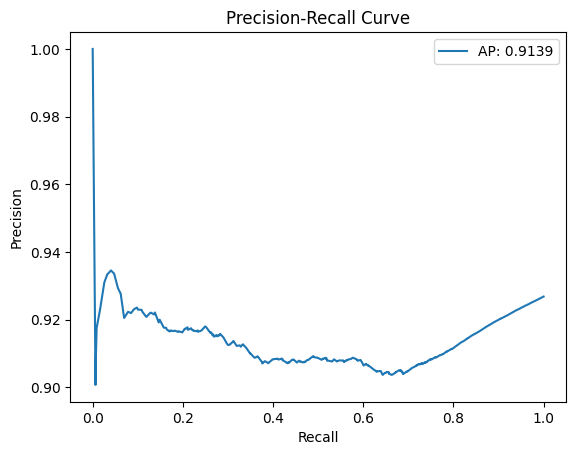

In [190]:
get_apr_roc_svm(params_dict={'C': 0.1, 'gamma': 0.1}, 
                base_models=[xgb_opt_s,rf_opt_s,nn_opt_s,sgd_opt_s], 
                X=X_sepsis, y=y_sepsis)

## <b>CDC DIABETES</b>

In [191]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X_cdc_raw = cdc_diabetes_health_indicators.data.features 
y_cdc_raw = cdc_diabetes_health_indicators.data.targets 

In [192]:
# normalizing

X_cdc = X_cdc_raw.drop(['PhysHlth', 'MentHlth', 'Education'], axis=1)

scaler = StandardScaler()
X_cdc[['BMI', 'Age', 'GenHlth', 'Income']] = scaler.fit_transform(X_cdc_raw[['BMI', 'Age', 'GenHlth', 'Income']])

X_cdc

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Income
0,1,1,1,1.757936,1,0,0,0,0,1,0,1,0,2.329121,1,0,0.316900,-1.474487
1,0,0,0,-0.511806,1,0,0,1,0,0,0,0,1,0.457294,0,0,-0.337933,-2.440138
2,1,1,1,-0.057858,0,0,0,0,1,0,0,1,1,2.329121,1,0,0.316900,0.939638
3,1,0,1,-0.209174,0,0,0,1,1,1,0,1,0,-0.478619,0,0,0.971733,-0.026012
4,1,1,1,-0.663122,0,0,0,1,1,1,0,1,0,-0.478619,0,0,0.971733,-0.991662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,2.514516,0,0,0,0,1,1,0,1,0,0.457294,0,1,-0.992766,0.456813
253676,1,1,1,-1.571019,0,0,0,0,0,0,0,1,0,1.393207,1,0,0.971733,-0.991662
253677,0,0,1,-0.057858,0,0,0,1,1,0,0,1,0,-1.414532,0,0,-1.975015,-1.957312
253678,1,0,1,-0.814438,0,0,0,0,1,1,0,1,0,0.457294,0,1,-0.337933,-2.440138


In [193]:
y_cdc = np.array(y_cdc_raw.astype(float)).ravel()
y_cdc

array([0., 0., 0., ..., 0., 0., 1.])

## XGB - CDC

Train=0.2
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92    174653
         1.0       0.46      0.25      0.33     28291

    accuracy                           0.85    202944
   macro avg       0.67      0.60      0.62    202944
weighted avg       0.83      0.85      0.84    202944

AP: 0.3829
ROC-AUC: 0.8040
 
 


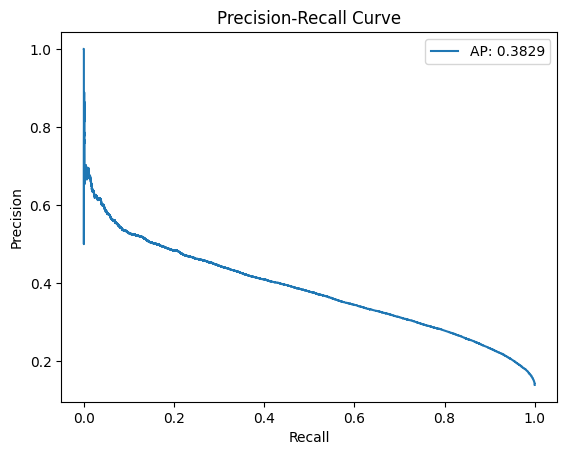

Train=0.5
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92    109241
         1.0       0.49      0.26      0.34     17599

    accuracy                           0.86    126840
   macro avg       0.69      0.61      0.63    126840
weighted avg       0.83      0.86      0.84    126840

AP: 0.4031
ROC-AUC: 0.8163
 
 


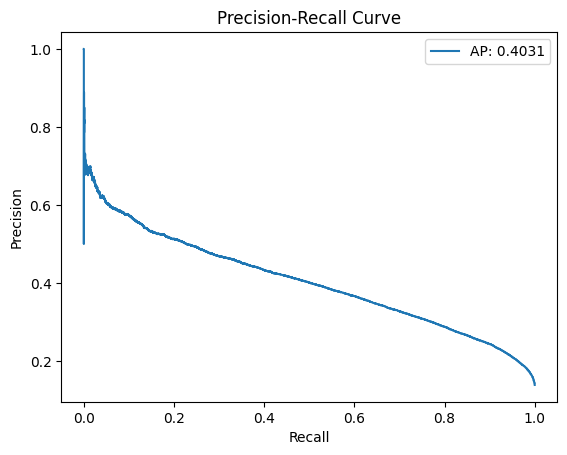

Train=0.8
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92     43739
         1.0       0.49      0.27      0.35      6997

    accuracy                           0.86     50736
   macro avg       0.69      0.61      0.63     50736
weighted avg       0.84      0.86      0.84     50736

AP: 0.4116
ROC-AUC: 0.8242
 
 


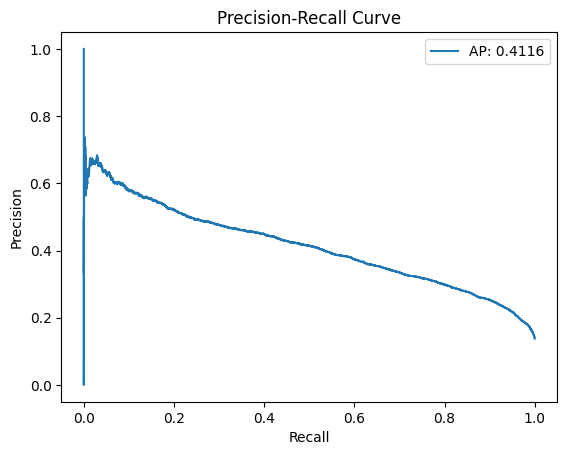

In [195]:
xgb_opt_c=get_apr_roc_xgb({'n_estimators':200, 'learning_rate':0.1,'max_depth':10},
                          X=X_cdc, y=y_cdc,
                          smote=True)

## RF - CDC

Train=0.2
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90    174653
         1.0       0.39      0.46      0.42     28291

    accuracy                           0.82    202944
   macro avg       0.65      0.67      0.66    202944
weighted avg       0.84      0.82      0.83    202944

AP: 0.3802
ROC-AUC: 0.8050
 
 


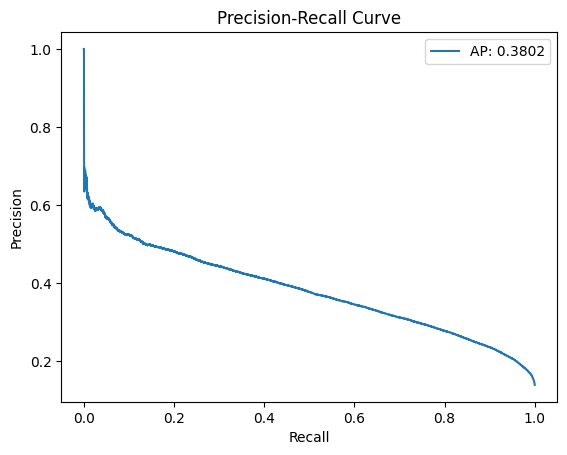

Train=0.5
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89    109241
         1.0       0.38      0.51      0.44     17599

    accuracy                           0.82    126840
   macro avg       0.65      0.69      0.66    126840
weighted avg       0.84      0.82      0.83    126840

AP: 0.3967
ROC-AUC: 0.8121
 
 


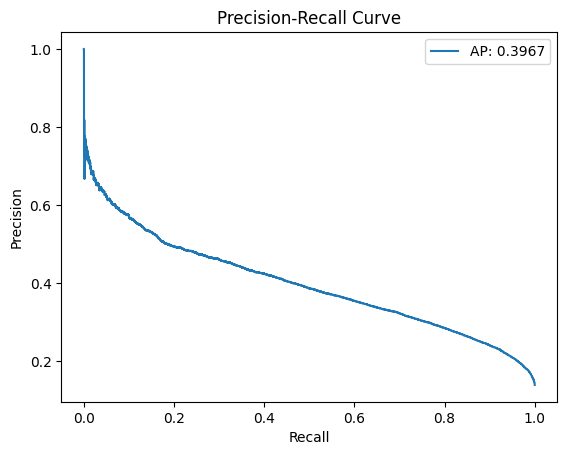

Train=0.8
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     43739
         1.0       0.38      0.55      0.45      6997

    accuracy                           0.81     50736
   macro avg       0.65      0.70      0.67     50736
weighted avg       0.85      0.81      0.83     50736

AP: 0.4043
ROC-AUC: 0.8192
 
 


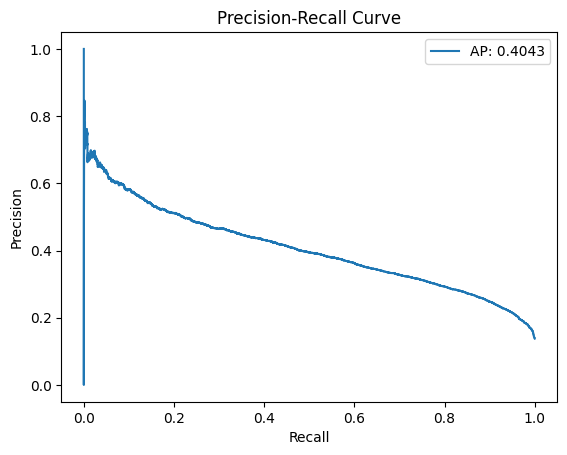

In [197]:
rf_opt_c=get_apr_roc_rf({'n_estimators':200, 'min_samples_split':2,'max_depth':20}, 
                        X=X_cdc, y=y_cdc,
                        smote=True)

## NN - CDC

6342/6342 ━━━━━━━━━━━━━━━━━━━━ 3s 399us/step
Train=0.2
              precision    recall  f1-score   support

         0.0       0.96      0.61      0.75    174653
         1.0       0.26      0.86      0.40     28291

    accuracy                           0.65    202944
   macro avg       0.61      0.74      0.58    202944
weighted avg       0.87      0.65      0.70    202944

AP: 0.4099
ROC-AUC: 0.8162
 
 


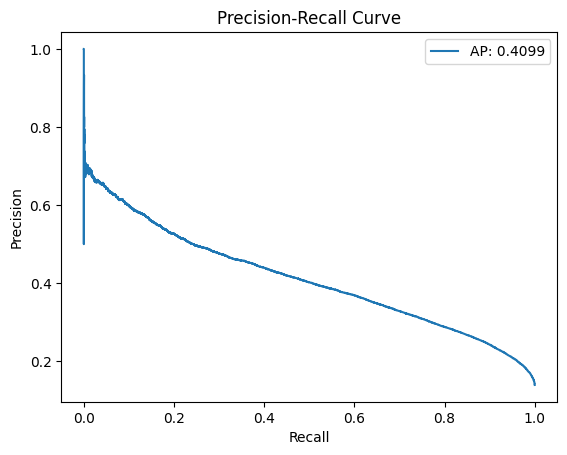

3964/3964 ━━━━━━━━━━━━━━━━━━━━ 2s 408us/step
Train=0.5
              precision    recall  f1-score   support

         0.0       0.96      0.61      0.75    109241
         1.0       0.26      0.86      0.40     17599

    accuracy                           0.64    126840
   macro avg       0.61      0.74      0.57    126840
weighted avg       0.87      0.64      0.70    126840

AP: 0.4137
ROC-AUC: 0.8196
 
 


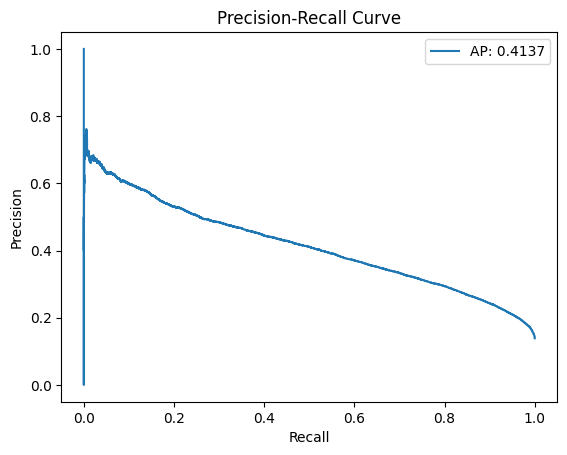

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step
Train=0.8
              precision    recall  f1-score   support

         0.0       0.97      0.62      0.75     43739
         1.0       0.27      0.88      0.41      6997

    accuracy                           0.65     50736
   macro avg       0.62      0.75      0.58     50736
weighted avg       0.87      0.65      0.71     50736

AP: 0.4227
ROC-AUC: 0.8297
 
 


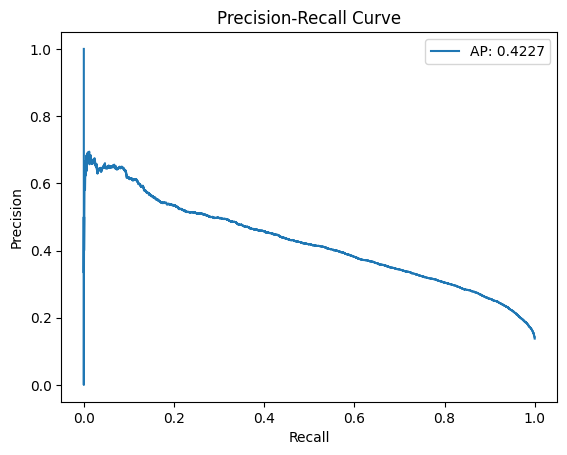

In [198]:
nn_opt_c=get_apr_roc_nn({'batch_size': 64, 'model__learning_rate': 0.001},
                        X=X_cdc,y=y_cdc,
                       feat_count=X_cdc.shape[1],
                       smote=True)

## SGD - CDC

Train=0.2
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82    174653
         1.0       0.31      0.76      0.44     28291

    accuracy                           0.73    202944
   macro avg       0.63      0.74      0.63    202944
weighted avg       0.86      0.73      0.77    202944

AP: 0.3893
ROC-AUC: 0.8158
 
 


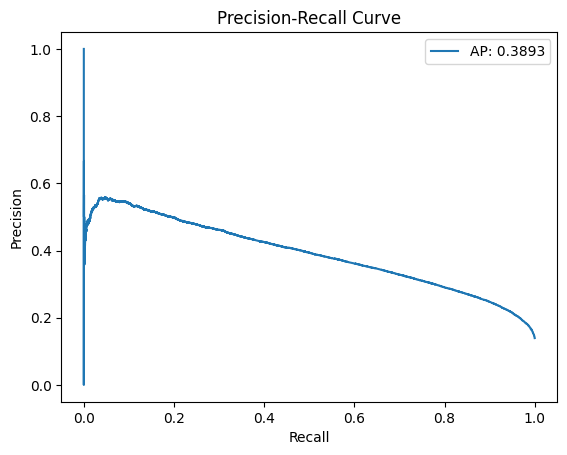

Train=0.5
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82    109241
         1.0       0.31      0.77      0.44     17599

    accuracy                           0.73    126840
   macro avg       0.63      0.74      0.63    126840
weighted avg       0.86      0.73      0.77    126840

AP: 0.3963
ROC-AUC: 0.8202
 
 


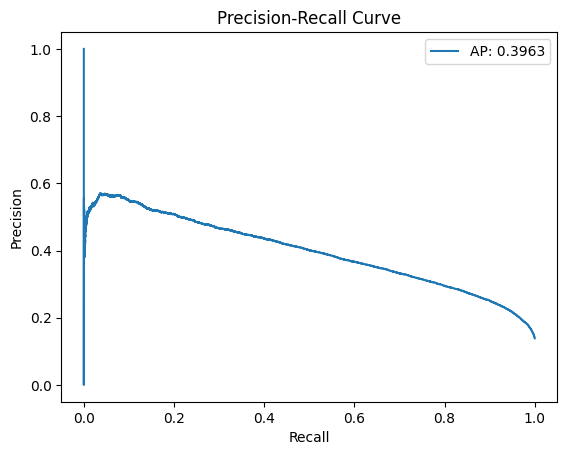

Train=0.8
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     43739
         1.0       0.31      0.77      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.73      0.77     50736

AP: 0.3996
ROC-AUC: 0.8237
 
 


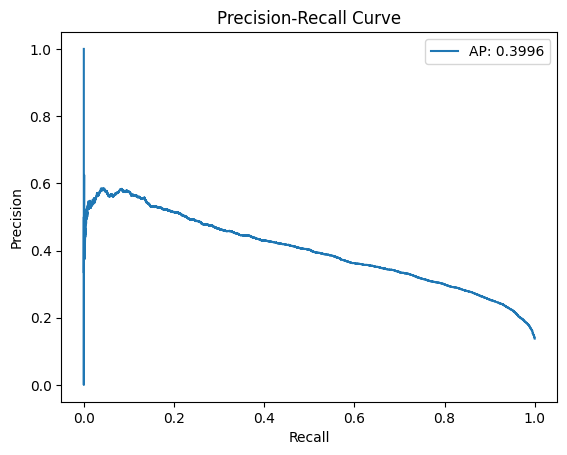

In [199]:
sgd_opt_c=get_apr_roc_sgd({'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'log_loss', 'tol': 1e-06}, 
                          X=X_cdc, y=y_cdc,
                          smote=True)

## SVM - CDC

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 3s 407us/step
Train=0.2
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95    174653
         1.0       0.69      0.58      0.63     28291

    accuracy                           0.91    202944
   macro avg       0.81      0.77      0.79    202944
weighted avg       0.90      0.91      0.90    202944

AP: 0.7104
ROC-AUC: 0.9040
 
 
 
 


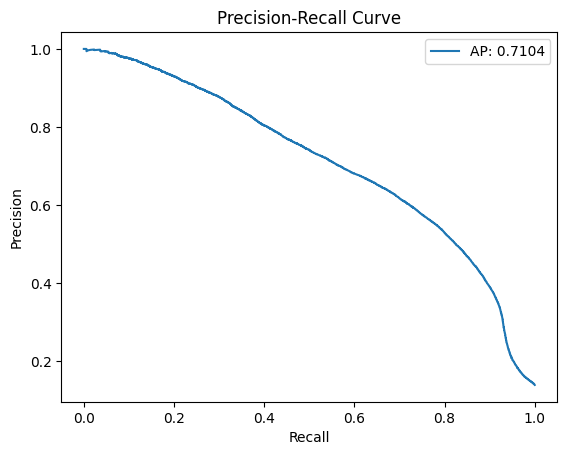

3964/3964 ━━━━━━━━━━━━━━━━━━━━ 2s 402us/step
3964/3964 ━━━━━━━━━━━━━━━━━━━━ 2s 404us/step
Train=0.5
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94    109241
         1.0       0.65      0.54      0.59     17599

    accuracy                           0.90    126840
   macro avg       0.79      0.74      0.76    126840
weighted avg       0.89      0.90      0.89    126840

AP: 0.6481
ROC-AUC: 0.8610
 
 
 
 


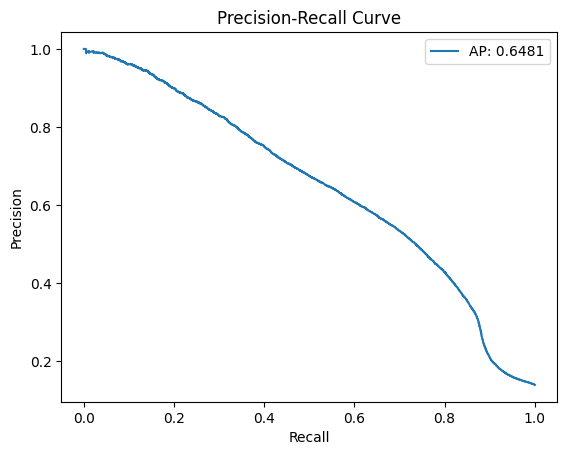

6342/6342 ━━━━━━━━━━━━━━━━━━━━ 3s 402us/step
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step
Train=0.8
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     43739
         1.0       0.41      0.29      0.34      6997

    accuracy                           0.84     50736
   macro avg       0.65      0.61      0.63     50736
weighted avg       0.83      0.84      0.83     50736

AP: 0.3159
ROC-AUC: 0.6788
 
 
 
 


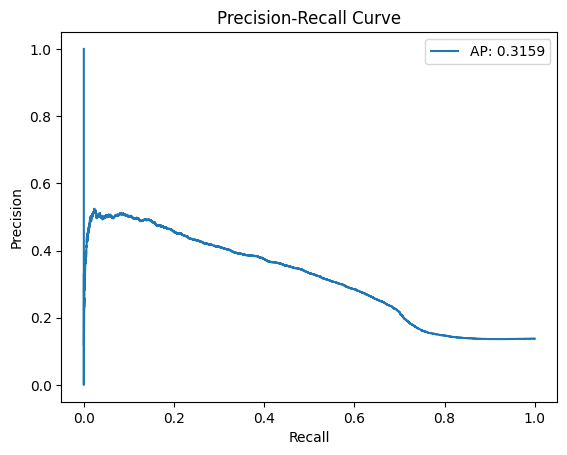

In [200]:
get_apr_roc_svm(params_dict={'C': 0.1, 'gamma': 0.1}, 
                base_models=[xgb_opt_c,rf_opt_c,nn_opt_c,sgd_opt_c], 
                X=X_cdc, y=y_cdc)

## <b>PHISHING</b>

In [16]:
# fetch dataset 
phishing_websites = fetch_ucirepo(id=327) 
  
# data (as pandas dataframes) 
X_phish_raw = phishing_websites.data.features 
y_phish_raw = phishing_websites.data.targets 

In [17]:
# Encoding scheme

X_dropped = X_phish_raw.drop(['links_in_tags'], axis=1)

def encode_binary(x):
    return (x>0).astype(float)

X_phish = X_dropped.apply(encode_binary)

y_encoded = y_phish_raw.apply(encode_binary)

y_phish=np.array(y_encoded).ravel()

## XGB - PHISH

Train=0.2
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      3888
         1.0       0.94      0.93      0.93      4956

    accuracy                           0.93      8844
   macro avg       0.92      0.92      0.92      8844
weighted avg       0.93      0.93      0.93      8844

AP: 0.9825
ROC-AUC: 0.9779
 
 


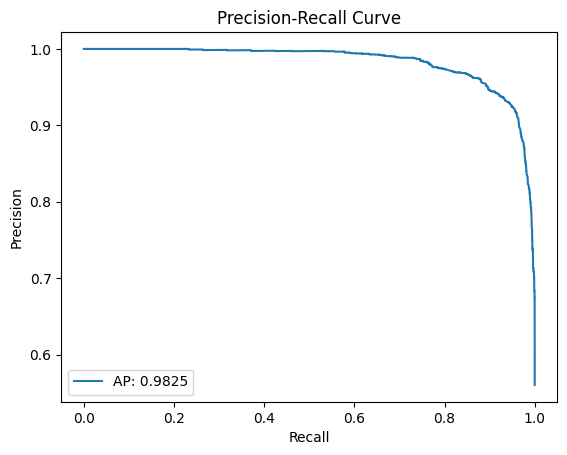

Train=0.5
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      2399
         1.0       0.94      0.95      0.95      3129

    accuracy                           0.94      5528
   macro avg       0.94      0.94      0.94      5528
weighted avg       0.94      0.94      0.94      5528

AP: 0.9897
ROC-AUC: 0.9870
 
 


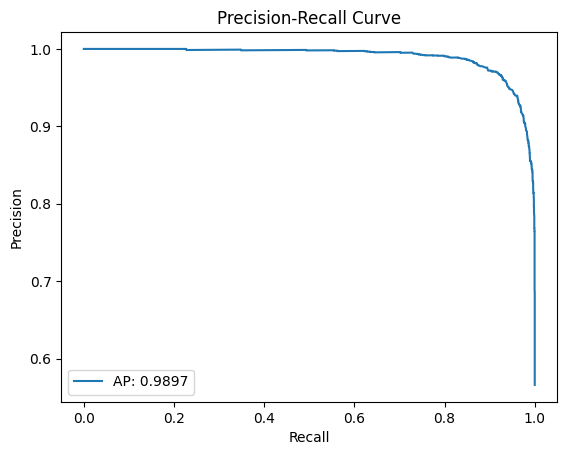

Train=0.8
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       956
         1.0       0.95      0.96      0.96      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211

AP: 0.9907
ROC-AUC: 0.9888
 
 


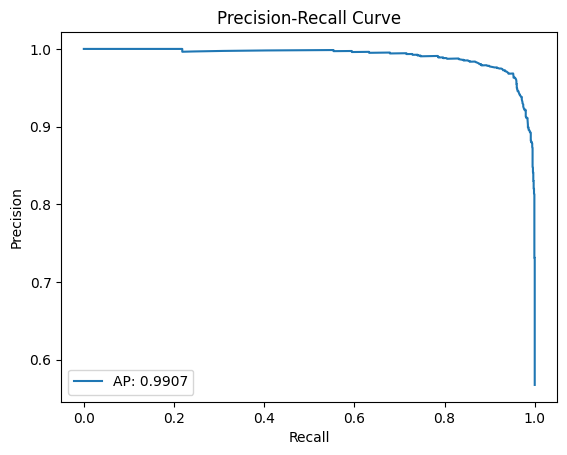

In [18]:
xgb_opt_p=get_apr_roc_xgb({'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200},
                          X=X_phish, y=y_phish)

## RF - PHISH

Train=0.2
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      3888
         1.0       0.93      0.94      0.94      4956

    accuracy                           0.93      8844
   macro avg       0.93      0.93      0.93      8844
weighted avg       0.93      0.93      0.93      8844

AP: 0.9800
ROC-AUC: 0.9765
 
 


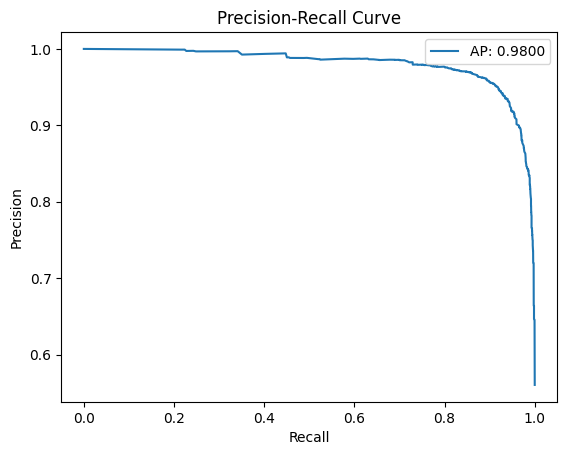

Train=0.5
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93      2399
         1.0       0.94      0.95      0.94      3129

    accuracy                           0.94      5528
   macro avg       0.94      0.94      0.94      5528
weighted avg       0.94      0.94      0.94      5528

AP: 0.9885
ROC-AUC: 0.9858
 
 


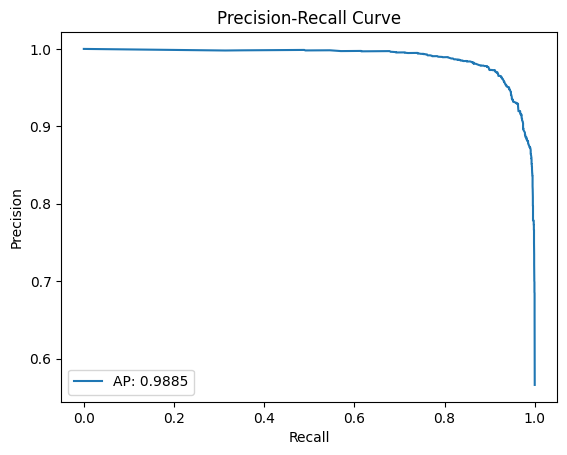

Train=0.8
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       956
         1.0       0.95      0.96      0.95      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211

AP: 0.9911
ROC-AUC: 0.9884
 
 


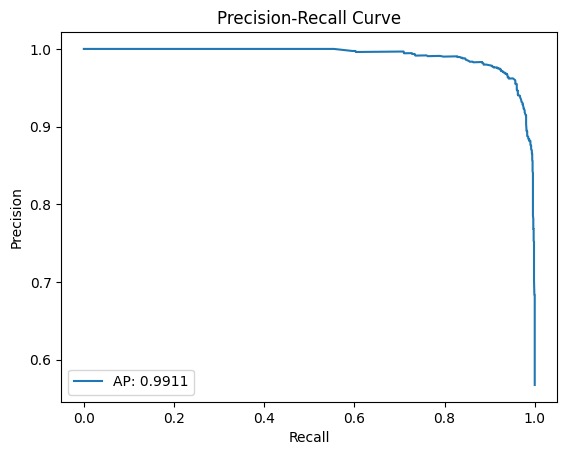

In [19]:
rf_opt_p=get_apr_roc_rf({'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}, 
                        X=X_phish, y=y_phish)

## NN - PHISH

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
Train=0.2
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.89      3888
         1.0       0.89      0.95      0.92      4956

    accuracy                           0.91      8844
   macro avg       0.91      0.90      0.91      8844
weighted avg       0.91      0.91      0.91      8844

AP: 0.9814
ROC-AUC: 0.9751
 
 


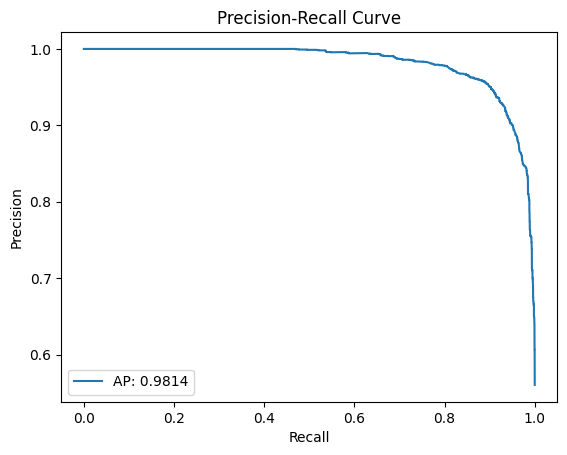

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
Train=0.5
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      2399
         1.0       0.90      0.97      0.93      3129

    accuracy                           0.92      5528
   macro avg       0.92      0.91      0.92      5528
weighted avg       0.92      0.92      0.92      5528

AP: 0.9860
ROC-AUC: 0.9813
 
 


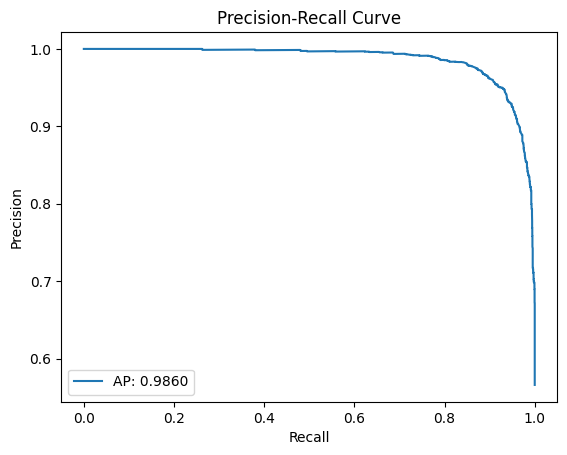

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
Train=0.8
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       956
         1.0       0.92      0.96      0.94      1255

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211

AP: 0.9871
ROC-AUC: 0.9839
 
 


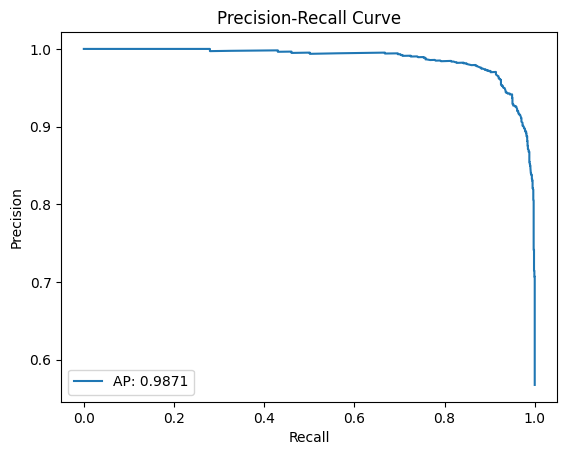

In [20]:
nn_opt_p=get_apr_roc_nn({'batch_size': 256, 'model__learning_rate': 0.01},
                        X=X_phish,y=y_phish,
                       feat_count=X_phish.shape[1])

## SGD - PHISH

Train=0.2
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      3888
         1.0       0.93      0.92      0.92      4956

    accuracy                           0.91      8844
   macro avg       0.91      0.91      0.91      8844
weighted avg       0.91      0.91      0.91      8844

AP: 0.9781
ROC-AUC: 0.9712
 
 


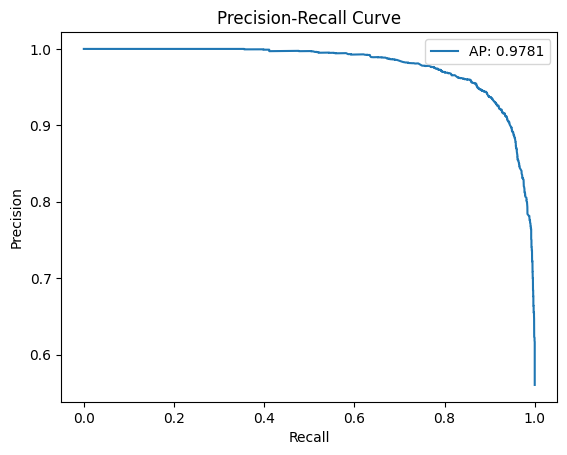

Train=0.5
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      2399
         1.0       0.93      0.92      0.92      3129

    accuracy                           0.91      5528
   macro avg       0.91      0.91      0.91      5528
weighted avg       0.91      0.91      0.91      5528

AP: 0.9789
ROC-AUC: 0.9716
 
 


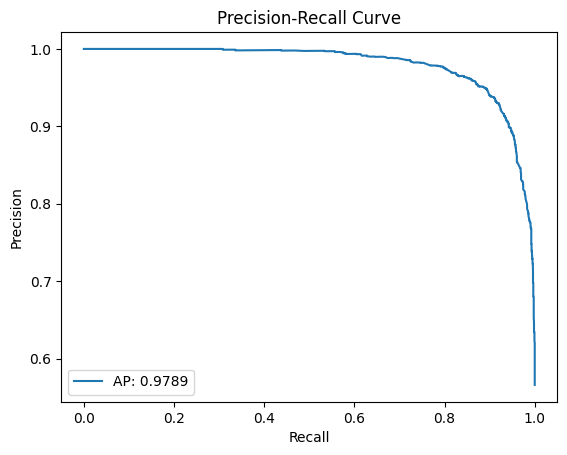

Train=0.8
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       956
         1.0       0.92      0.93      0.93      1255

    accuracy                           0.92      2211
   macro avg       0.92      0.92      0.92      2211
weighted avg       0.92      0.92      0.92      2211

AP: 0.9794
ROC-AUC: 0.9729
 
 


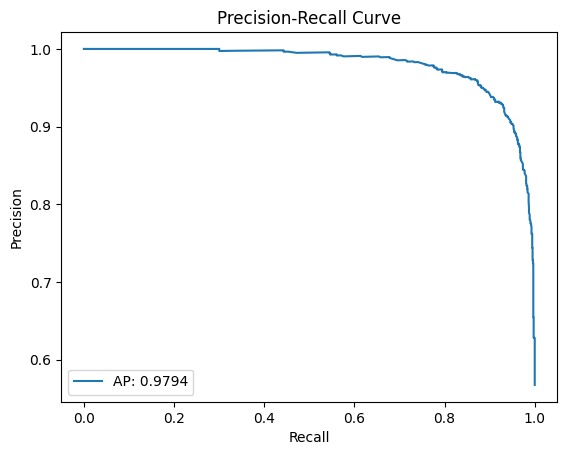

In [21]:
sgd_opt_p=get_apr_roc_sgd({'alpha': 0.001, 'l1_ratio': 0.85, 'loss': 'log_loss', 'tol': 1e-05}, 
                          X=X_phish, y=y_phish)

## SVM - PHISH

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
Train=0.2
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3888
         1.0       0.96      0.98      0.97      4956

    accuracy                           0.96      8844
   macro avg       0.96      0.96      0.96      8844
weighted avg       0.96      0.96      0.96      8844

AP: 0.9930
ROC-AUC: 0.9944
 
 
 
 


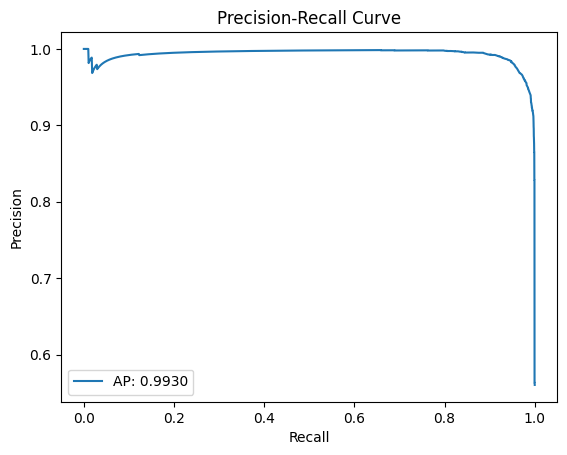

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
Train=0.5
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      2399
         1.0       0.96      0.97      0.97      3129

    accuracy                           0.96      5528
   macro avg       0.96      0.96      0.96      5528
weighted avg       0.96      0.96      0.96      5528

AP: 0.9904
ROC-AUC: 0.9921
 
 
 
 


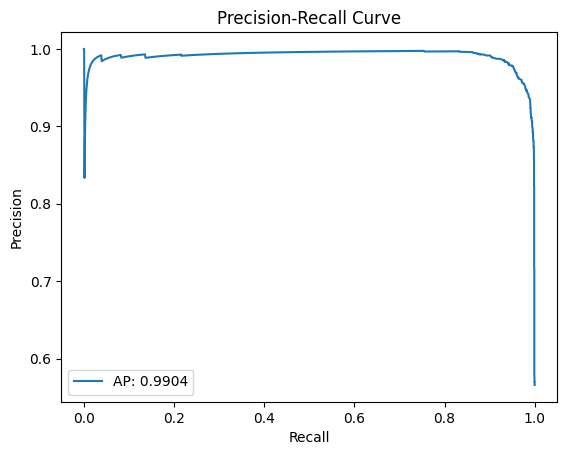

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
Train=0.8
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       956
         1.0       0.95      0.95      0.95      1255

    accuracy                           0.94      2211
   macro avg       0.94      0.94      0.94      2211
weighted avg       0.94      0.94      0.94      2211

AP: 0.9811
ROC-AUC: 0.9842
 
 
 
 


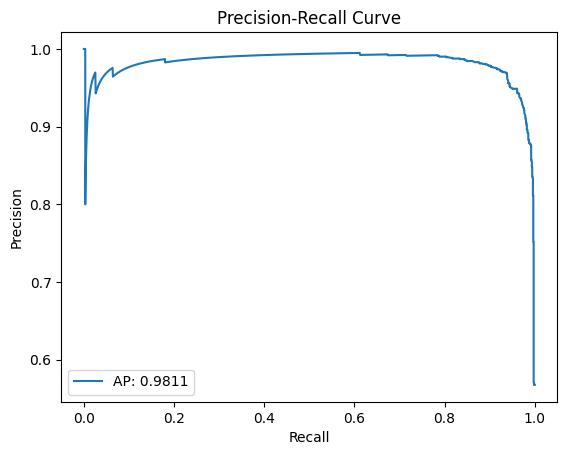

In [22]:
get_apr_roc_svm(params_dict={'C': 10, 'gamma': 0.1}, 
                base_models=[xgb_opt_p,rf_opt_p,nn_opt_p,sgd_opt_p], 
                X=X_phish, y=y_phish)